In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

In [3]:
titanic_train = pd.read_csv('train.csv')
titanic_test = pd.read_csv('test.csv') 

titanic = pd.concat([titanic_train, titanic_test], axis=0)
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Reseting index to ensure unique index labels

In [4]:
titanic.reset_index(drop=True, inplace=True)

Exploratory Data Analysis

In [5]:
titanic.shape

(1309, 12)

In [6]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


Summary Statistics

In [7]:
titanic.describe().round()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.0,891.0,1309.0,1046.0,1309.0,1309.0,1308.0
mean,655.0,0.0,2.0,30.0,0.0,0.0,33.0
std,378.0,0.0,1.0,14.0,1.0,1.0,52.0
min,1.0,0.0,1.0,0.0,0.0,0.0,0.0
25%,328.0,0.0,2.0,21.0,0.0,0.0,8.0
50%,655.0,0.0,3.0,28.0,0.0,0.0,14.0
75%,982.0,1.0,3.0,39.0,1.0,0.0,31.0
max,1309.0,1.0,3.0,80.0,8.0,9.0,512.0


Distribution of target variable 'Survived'

C:\Users\PC\AppData\Local\Temp\ipykernel_12224\4008323612.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=titanic, x='Survived', palette='coolwarm')


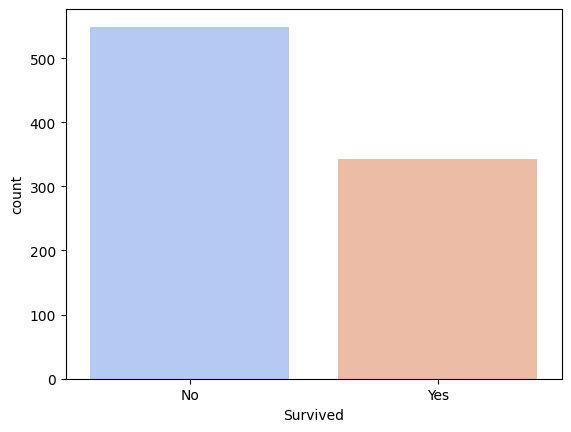

In [8]:
sns.countplot(data=titanic, x='Survived', palette='coolwarm')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

Distribution of variable 'Age'

<Axes: xlabel='Age', ylabel='Count'>

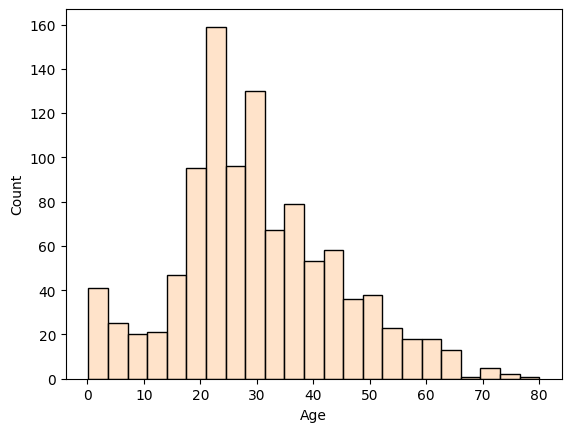

In [9]:
sns.histplot(data=titanic, x='Age', color='peachpuff')

Survival count by gender

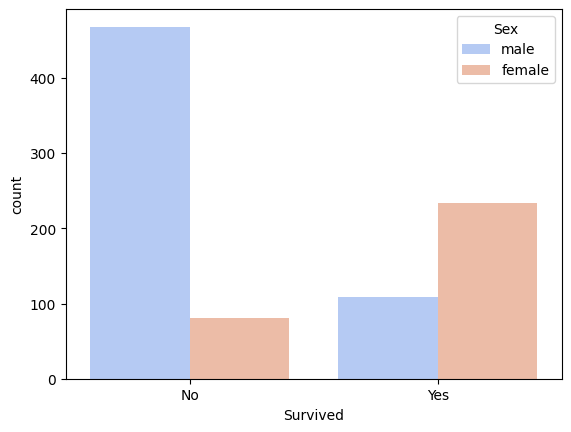

In [10]:
sns.countplot(data=titanic, x='Survived', hue='Sex', palette='coolwarm')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

Survival count by passenger class

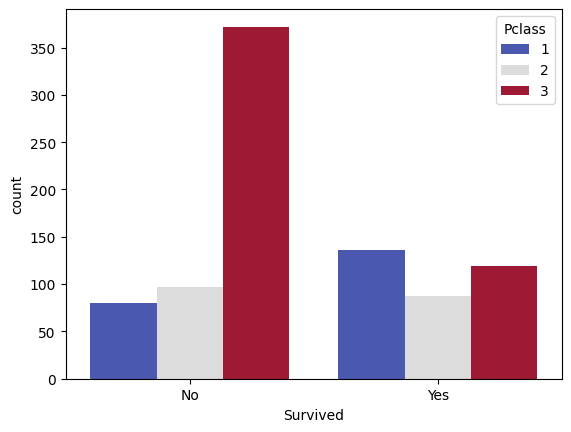

In [11]:
sns.countplot(data=titanic, x='Survived', hue='Pclass', palette='coolwarm')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

Data Preprocessing & Feature Engineering

Creating a 'Cabin Category' variable 

In [12]:
all_cabins = titanic['Cabin'].unique()
cabin_categories = set()

for cabin in all_cabins:
    if pd.notna(cabin):  
        cabin_categories.add((cabin[0]))

titanic['CabinCategory'] = titanic['Cabin'].apply(lambda cabin: cabin[0] if pd.notna(cabin) else np.nan)
print(f"Cabin Categories: {titanic['CabinCategory'].unique()}")

Cabin Categories: [nan 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']


Visualizing Cabin Categories

C:\Users\PC\AppData\Local\Temp\ipykernel_12224\137912881.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=titanic, x='CabinCategory', palette='coolwarm')


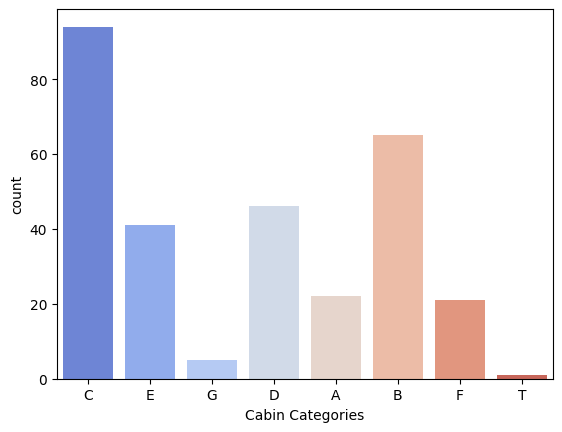

In [13]:
sns.countplot(data=titanic, x='CabinCategory', palette='coolwarm')
plt.xlabel('Cabin Categories')
plt.show()

Handling missing values

In [14]:
titanic.isna().sum()

PassengerId         0
Survived          418
Pclass              0
Name                0
Sex                 0
Age               263
SibSp               0
Parch               0
Ticket              0
Fare                1
Cabin            1014
Embarked            2
CabinCategory    1014
dtype: int64

Imputing null values with mode for 'CabinCategory' variable and mean for 'Age' variable

In [15]:
new_cabin_category = titanic['CabinCategory'].mode()[0]
print("Cabin Category Mode:", new_cabin_category)
titanic['CabinCategory'].fillna(new_cabin_category, inplace=True)

new_age = titanic['Age'].mean().round()
print("Age Mean:", new_age)
titanic['Age'].fillna(new_age, inplace=True)

Cabin Category Mode: C
Age Mean: 30.0


C:\Users\PC\AppData\Local\Temp\ipykernel_12224\1767647039.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic['CabinCategory'].fillna(new_cabin_category, inplace=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_12224\1767647039.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a cop

Dropping 'Cabin' variable due to large amount of null values

In [16]:
titanic.drop(columns=['Cabin'], inplace=True)

Removing remaining null values

In [17]:
titanic.dropna(inplace=True)

Confirming there are no more missing values

In [18]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
CabinCategory    0
dtype: int64

Outlier Detection 

Visualizing features after outlier removal

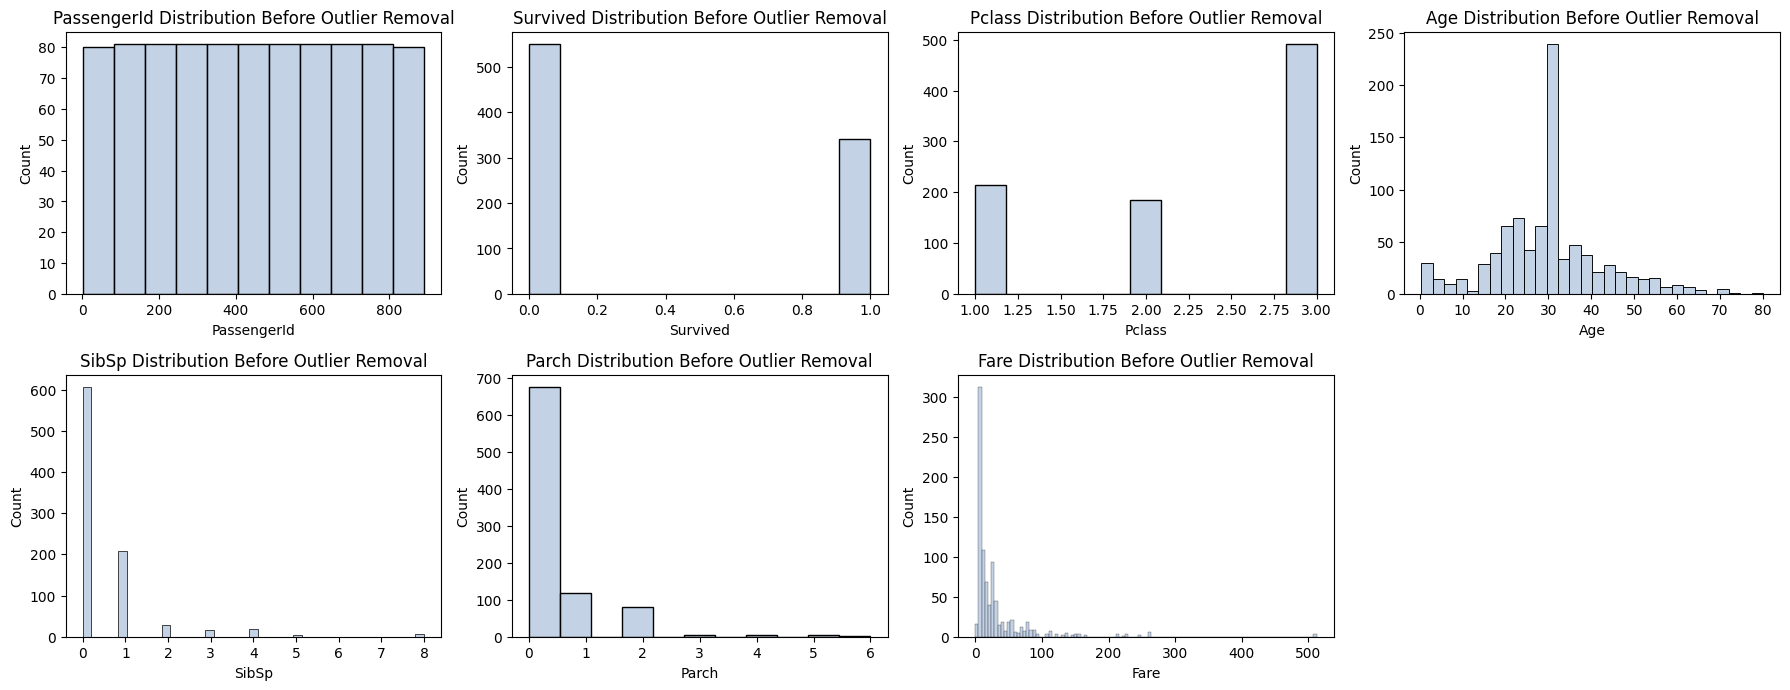

In [19]:
numerical = ['PassengerId',	'Survived',	'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

plt.figure(figsize=(18, 10))
for i, feature in enumerate(numerical):
    plt.subplot(3, 4, i+1)
    sns.histplot(titanic[feature], color='lightsteelblue')
    plt.title(f'{feature} Distribution Before Outlier Removal')

plt.tight_layout()
plt.show()

Outlier removal using Z-Score method

In [ ]:
# numerical = ['PassengerId',	'Survived',	'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

# threshold = 3
# for col in numerical:
#     titanic[col + '_Zscore'] = zscore(titanic[col])
#     titanic = titanic[titanic[col + '_Zscore'].abs() <= threshold]

# titanic.drop(columns=[col + '_Zscore' for col in numerical], inplace=True)

Visualizing features after outlier removal

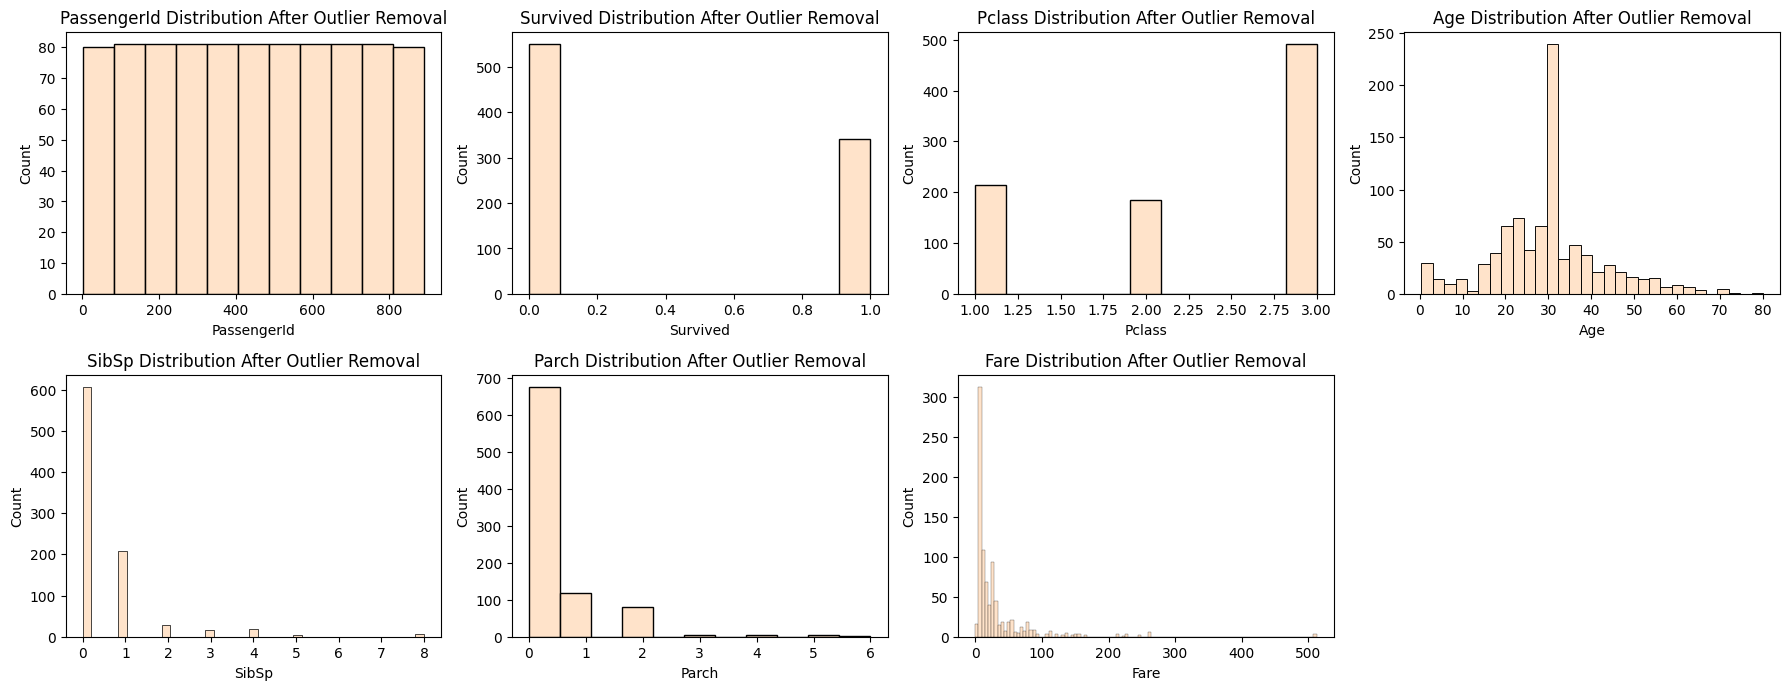

In [20]:
plt.figure(figsize=(18, 10))
for i, feature in enumerate(numerical):
    plt.subplot(3, 4, i+1)
    sns.histplot(titanic[feature], color='peachpuff')
    plt.title(f'{feature} Distribution After Outlier Removal')

plt.tight_layout()
plt.show()

In [21]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,CabinCategory
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,C
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,C
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,C
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,C


One hot encoding

In [22]:
print(f"'Embarked' values:{titanic['Embarked'].unique()}")
print(f"'Cabin Category' values:{titanic['CabinCategory'].unique()}")
print(f"'Sex' values:{titanic['Sex'].unique()}")

'Embarked' values:['S' 'C' 'Q']
'Cabin Category' values:['C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']
'Sex' values:['male' 'female']


Performing one hot encoding for columns 'Embarked', 'CabinCategory' and 'Sex'

In [23]:
titanic = pd.get_dummies(titanic, columns=['Embarked', 'CabinCategory', 'Sex'])
titanic.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked_C,...,CabinCategory_A,CabinCategory_B,CabinCategory_C,CabinCategory_D,CabinCategory_E,CabinCategory_F,CabinCategory_G,CabinCategory_T,Sex_female,Sex_male
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,False,...,False,False,True,False,False,False,False,False,False,True
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,True,...,False,False,True,False,False,False,False,False,True,False
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,False,...,False,False,True,False,False,False,False,False,True,False
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,False,...,False,False,True,False,False,False,False,False,True,False
4,5,0.0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,False,...,False,False,True,False,False,False,False,False,False,True


Model Building

In [24]:
X = titanic.drop(['Survived', 'Name', 'Ticket'], axis=1)
y = titanic['Survived']

In [25]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [27]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [28]:
logistic_regression = LogisticRegression()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
svc = SVC()

In [29]:
from sklearn.model_selection import GridSearchCV

param_grid_logistic_regression = {
    'C': [0.1, 1],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

param_grid_decision_tree = {
    'max_depth': [2, 3],
    'min_samples_split': [2, 5]
}

param_grid_random_forest = {
    'n_estimators':  [30, 60],
    'max_depth': [15, 30],
    'min_samples_split': [10, 30]
}

param_grid_svm = {
    'C': [0.1, 1],
    'kernel': ['linear']
}

models = {
    'Logistic Regression': (LogisticRegression(), param_grid_logistic_regression),
    'Decision Tree': (DecisionTreeClassifier(), param_grid_decision_tree),
    'Random Forest': (RandomForestClassifier(), param_grid_random_forest),
    'Linear SVM': (SVC(probability=True), param_grid_svm)
}

for name, (model, param_grid) in models.items():
    print(name)

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', error_score='raise')
    grid_search.fit(X_train_scaled, y_train)
    
    print("Best Parameters:", grid_search.best_params_)
    
    best_model = grid_search.best_estimator_
    
    best_model.fit(X_train_scaled, y_train)
    
    y_train_pred = best_model.predict_proba(X_train_scaled)[:, 1]
    auc_train = round(roc_auc_score(y_train, y_train_pred) * 100)
    print(f"Training AUC Score: {auc_train}%")
    
    y_val_pred = best_model.predict_proba(X_val_scaled)[:, 1]
    auc_val = round(roc_auc_score(y_val, y_val_pred) * 100)
    print(f"Validation AUC Score: {auc_val}%")
    
    y_test_pred = best_model.predict_proba(X_test_scaled)[:, 1]
    auc_test = round(roc_auc_score(y_test, y_test_pred) * 100)
    print(f"Testing AUC Score: {auc_test}%")
    
    print("\n")

Logistic Regression
Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Training AUC Score: 86%
Validation AUC Score: 84%
Testing AUC Score: 86%


Decision Tree
Best Parameters: {'max_depth': 3, 'min_samples_split': 2}
Training AUC Score: 87%
Validation AUC Score: 85%
Testing AUC Score: 88%


Random Forest
Best Parameters: {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 60}
Training AUC Score: 98%
Validation AUC Score: 82%
Testing AUC Score: 88%


Linear SVM
Best Parameters: {'C': 1, 'kernel': 'linear'}
Training AUC Score: 84%
Validation AUC Score: 85%
Testing AUC Score: 84%


